In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import arviz as az
import pymc3 as pm

from scipy.special import expit as logistic

In [2]:
az.style.use('arviz-darkgrid')

In [3]:
%%HTML
<style>

.CodeMirror {
    width: 100vw;
}

.container {
    width: 99% !important;
}

.rendered_html {
  font-size:0.8em;
}
.rendered_html table, .rendered_html th, .rendered_html tr, .rendered_html td {
     font-size: 100%;
}


body {
  font-family: Ubuntu;
  background: #F0F0F0;
  background-color: #F0F0F0;
}


.reveal h1,
.reveal h2,
.reveal h3,
.reveal h4,
.reveal h5,
.reveal h6 {
  margin: 0 0 20px 0;
  color: #2a2eec;
  font-family: Ubuntu;
  line-height: 0.9em;
  letter-spacing: 0.02em;
  text-transform: none;
  text-shadow: none;
}

.reveal blockquote {
  display: block;
  position: relative;
  background: #fa7c17;
  border-radius: 15px;
  box-shadow: 0px 0px 2px rgba(0, 0, 0, 0.2);
  font-weight: bold;
}

</style>

In [4]:
from traitlets.config.manager import BaseJSONConfigManager
path = "/home/osvaldo/anaconda3/etc/jupyter/nbconfig"
cm = BaseJSONConfigManager(config_dir=path)
cm.update("livereveal", {
              "theme": "serif",
              "transition": "zoom",
              "start_slideshow_at": "selected",
              "controls": "True",
              "progress": "False",
              "shortcut": "False"});

##### <center><img src="img/logo_inst.png" width="750">
<br>
<br>
<br>
<br>
<h1 align="center">Hierarchical models</h1>
<h2 align="center">Partially pooling data</h2> 
    


<br>
<br>
<br>
<br>
<br>

## Aims

* Learn how to build hierarchical models
* Discuss the concept of shrinkage and regularization
* Discuss the implications of partially pooling data

## Hierarchical models

<center>
<img src="img/pooling.png" width=500>


<center>
<img src="img/hierarchical_model.png" width=500>

## Hierarchical Chemical Shifts

* Proteins are molecules formed by a variable number of 20 units in a variable order

* For each one of this units we can measure a "chemical shift" and we can also compute it using Quantum Chemistry methods

* As each one of the 20 units are chemical different there is variability between units

* As the chemical environment (the protein) affects the value of a chemical shift there is variability within each unit


In [5]:
cs_data = pd.read_csv('../datos/chemical_shifts_theo_exp.csv')
diff = cs_data.theo - cs_data.exp
idx = pd.Categorical(cs_data['aa']).codes
groups = len(np.unique(idx))

cs_data.tail()

,ID,aa,theo,exp
1771,1KS9,LYS,55.79,57.51
1772,1KS9,ARG,58.91,59.02
1773,1KS9,LYS,59.49,58.92
1774,1KS9,GLU,59.48,58.36
1775,1KS9,SER,58.07,60.55


In [6]:
with pm.Model() as cs_nh:         
    μ = pm.Normal('μ', mu=0, sd=10, shape=groups) 
    σ = pm.HalfNormal('σ', sd=10, shape=groups) 
 
    y = pm.Normal('y', mu=μ[idx], sd=σ[idx], observed=diff) 
     
    trace_cs_nh = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [σ, μ]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:06<00:00, 455.02draws/s]


In [7]:
with pm.Model() as cs_h:
    # hyper_priors
    μ_mu = pm.Normal('μ_mu', mu=0, sd=10)
    μ_sd = pm.HalfNormal('μ_sd', 10)

    # priors
    μ = pm.Normal('μ', mu=μ_mu, sd=μ_sd, shape=groups) 
    σ = pm.HalfNormal('σ', sd=10, shape=groups) 

    y = pm.Normal('y', mu=μ[idx], sd=σ[idx], observed=diff) 

    trace_cs_h = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [σ, μ, μ_sd, μ_mu]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:09<00:00, 302.59draws/s]


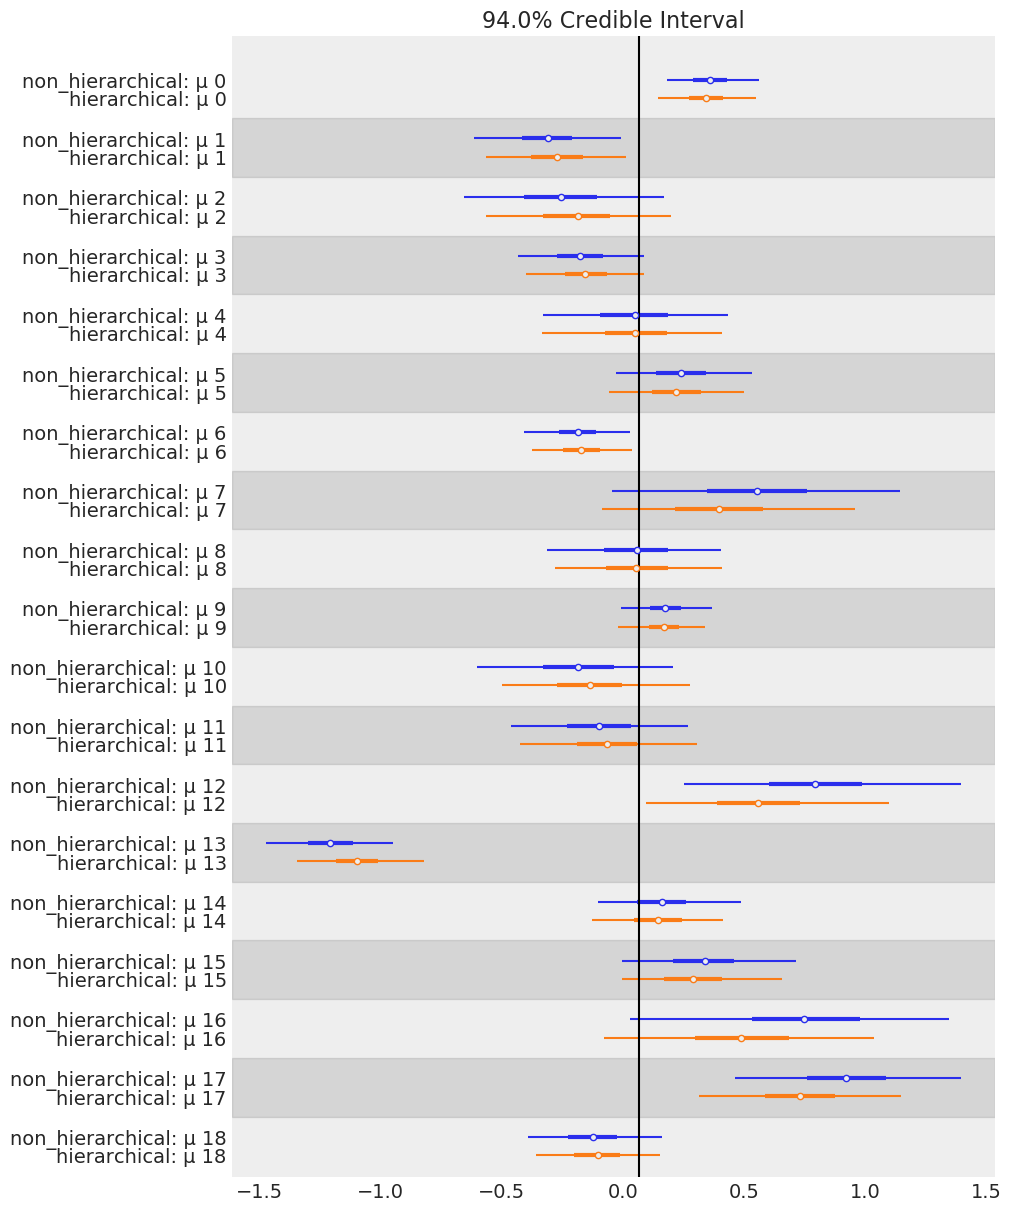

In [8]:
_, axes = az.plot_forest([trace_cs_nh, trace_cs_h], model_names=['non_hierarchical', 'hierarchical'],
              var_names='μ', combined=True, r_hat=False, ess=False, figsize=(10, 12),
              colors='cycle');
y_lims = axes[0].get_ylim()
axes[0].vlines(trace_cs_h['μ_mu'].mean(), *y_lims);

## Advantages of hierarchical models

<br>

* Regularization:
    * Improved estimates for repeat sampling
    * Improved estimates for imbalance in sampling
  
* Estimates of variation among groups.

* Avoid averaging, retain variation.

<br>

## Shrinkage and advantages of hierarchical models


* Each group informs the others and is informed by the others


* The estimation of each group is _pooled_ or _shrink_ toward the common mean


* The amount of shrinkage is not the same for every group
    * Typical groups are less affected
    * Groups with larger sample size are less affected


* Retain variation at the group level and among groups  


* Hierarchical model is a form of regularization

##  Multilevel tadpoles

<br>
<br>

* We have 48 tanks filled with red frogs' tadpoles


* We want to model the probability of survival


* Conditions such as temperature, pH, light, etc vary slightly from tank to tank


* We can think of each tank as a cluster or group


<br>


[statistical rethinking](https://xcelab.net/rm/statistical-rethinking/)

In [9]:
d = pd.read_csv('../datos/reedfrogs.csv', sep=",")
d.head()

,density,pred,size,surv,propsurv
0,10,no,big,9,0.9
1,10,no,big,10,1.0
2,10,no,big,7,0.7
3,10,no,big,10,1.0
4,10,no,small,9,0.9


In [10]:
with pm.Model() as model_tadpoles:
    # Hyperpriors
    μ = pm.Normal('μ', 0., 1.)
    σ = pm.HalfCauchy('σ', 1.)
    # Prior
    a_tank = pm.Normal('a_tank', μ, σ, shape=d.shape[0])
    p = pm.math.invlogit(a_tank) #
    #likelihood
    surv = pm.Binomial('surv', n=d.density, p=p, observed=d.surv)
    
    trace_tadpoles = pm.sample(2000, tune=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a_tank, σ, μ]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:14<00:00, 539.65draws/s]


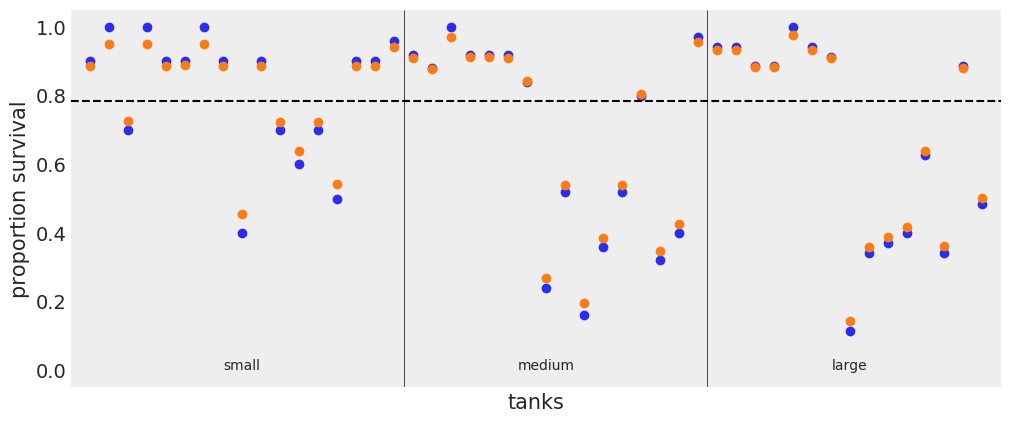

In [11]:
# extract PyMC3 samples
post = pm.trace_to_dataframe(trace_tadpoles, varnames=['a_tank'])

# compute median intercept for each tank
# also transform to probability with logistic
d.loc[:, 'propsurv_est'] = pd.Series(logistic(post.median(axis=0).values), index=d.index)

_, ax = plt.subplots(1, 1, figsize=(12, 5))
# display raw proportions surviving in each tank
ax.scatter(np.arange(0, 48), d.propsurv, color='C0')
ax.scatter(np.arange(0, 48), d.propsurv_est, color='C1')
ax.hlines(logistic(np.median(trace_tadpoles['μ'], axis=0)), -1, 49, linestyles='--')
idx = d.density[d.density.diff() > 0].index
ax.vlines(idx + 0.5, -.05, 1.05, lw=.5)
for i, t in zip(np.linspace(0, 48, 7)[1::2], ('small', 'medium', 'large')):
    ax.text(i, 0, t, horizontalalignment='center')
ax.set_xlabel('tanks')
ax.set_ylabel('proportion survival')
ax.set_xlim(-1, 48)
ax.set_xticks([])
ax.set_ylim(-.05, 1.05)
ax.grid(False)

### Hierarchical coins


<img src="img/modelo_3_monedas_jerarquico.png" width=250>


\begin{align}
\mu &\sim \operatorname{Beta}(\alpha, \beta) \\
\kappa &\sim \operatorname{Gamma}(s, r) \\
\theta &\sim \operatorname{Beta}(\alpha=\mu  \kappa, \beta=(1 - \mu)  \kappa) \\
y &\sim \operatorname{Bin}(n=1, p=\theta)
\end{align}

[Doing Bayesian Data Analysis](https://sites.google.com/site/doingbayesiandataanalysis/)

In [12]:
N = [30, 30, 30]  # Number of trials for each coin
z = [3, 3, 3]  # Number of heads for each coin

# index vector
coins = np.repeat(np.arange(len(N)), N)
# list filled with  zeros (tails) and ones (heads)
data = []
for i in range(len(N)):
    data.extend(np.repeat([1, 0], [z[i], N[i]-z[i]]))

In [13]:
with pm.Model() as modelo_j:
    # hiperparameters
    μ = pm.Beta('μ', 2., 2.)
    κ = pm.HalfNormal('κ', 10.)

    # priors
    θ = pm.Beta('θ', μ * κ, (1 - μ) * κ, shape=len(N))
    # likelihood
    y = pm.Bernoulli('y', p=θ[coins], observed=data)

    trace_j = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [θ, κ, μ]
Sampling 2 chains: 100%|██████████| 5000/5000 [00:10<00:00, 463.55draws/s]


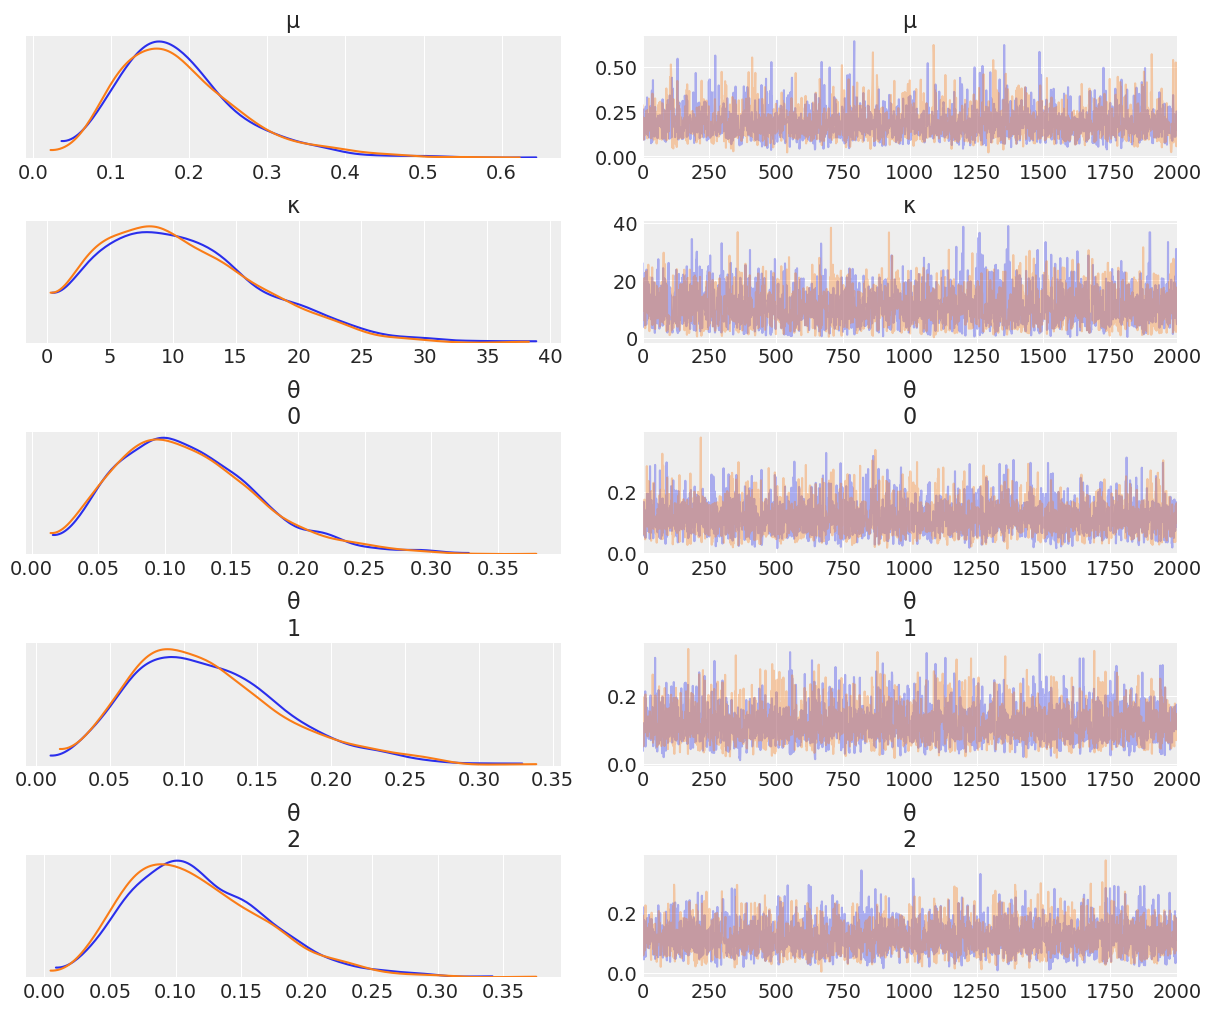

In [14]:
az.plot_trace(trace_j);

In [15]:
az.summary(trace_j)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
μ,0.189,0.082,0.054,0.343,0.002,0.001,2664.0,2574.0,2799.0,2706.0,1.0
κ,10.857,6.302,0.744,21.925,0.128,0.090,2434.0,2434.0,2211.0,2105.0,1.0
θ[0],0.117,0.053,0.026,0.213,0.001,0.001,4069.0,3886.0,3885.0,2414.0,1.0
θ[1],0.118,0.053,0.030,0.221,0.001,0.001,3633.0,3597.0,3393.0,2187.0,1.0
θ[2],0.117,0.052,0.029,0.212,0.001,0.001,3830.0,3793.0,3574.0,2631.0,1.0


## Exercises 

Repeat the hierarchical coins example, this time use the following data:

* z = [3,3,3] 
* z = [18,3,18]

Record the value of the estimated means for $\theta$, so you can compare the 3 examples (including `z = [18,18,18]`)